# Практика SQL. Анализ данных StackOverflow

Вы будете работать с базой данных StackOverflow — сервиса вопросов и ответов о программировании. StackOverflow похож на социальную сеть — пользователи сервиса задают вопросы, отвечают на посты, оставляют комментарии и ставят оценки другим ответам.  
Вы будете работать с версией базы, где хранятся данные о постах за 2008 год, но в таблицах вы найдёте информацию и о более поздних оценках, которые эти посты получили.  
  
Вам нужно написать несколько SQL-запросов.  

Необходимые данные находятся в таблицах схемы stackoverflow

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [55]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [56]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [57]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [58]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [59]:
# напишите запрос
query_1 = '''SELECT date_trunc('month', creation_date) as month_date, sum(views_count) as total_views
FROM stackoverflow.posts
WHERE extract( YEAR from creation_date) = '2008'
GROUP BY month_date
ORDER BY total_views DESC
'''

# выполните запрос

In [60]:
sample_df_1 = pd.read_sql_query(query_1, con=engine, index_col='month_date')
sample_df_1

,total_views
month_date,
2008-09-01,452928568
2008-10-01,365400138
2008-11-01,221759651
2008-12-01,197792841
2008-08-01,131367083
2008-07-01,669895


<details>

<summary>Подсказка</summary>
Используйте функцию для усечения даты, а затем сгруппируйте и отсортируйте данные.
</details>

Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

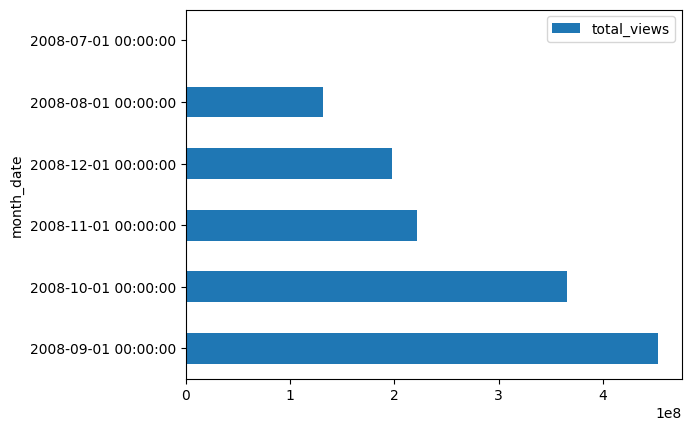

In [61]:
sample_df_1.plot.barh()
plt.show()

Вывод: можно увидеть, что осенние месяцы являются лидерами по количеству просмотров постов на платформе. Показатели декабря уступают показателям ноября, но незначительно. При этом, август и июль являются самыми малочисленными по колчиеству просомтров месяцами. Можно предположить, что данный факт связан с особенностью платформы. На осень традиционно приходится начало учебного года. Возможно, студенты или люди, которые начинают изучать програмирование самостоятельно или же на курсах, начинают активно использовать платформу. В то время как на лето приходится сезон отпусков и каникул.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [62]:
# напишите запрос
query_2 = '''SELECT u.display_name, count(DISTINCT p.user_id)
FROM stackoverflow.users as u
JOIN stackoverflow.posts as p ON p.user_id = u.id
JOIN stackoverflow.post_types as pt ON pt.id = p.post_type_id
WHERE pt.type = 'Answer' AND
p.creation_date::date BETWEEN u.creation_date AND (u.creation_date::date + INTERVAL '1 month')
GROUP BY u.display_name
HAVING count(p.user_id)>100
ORDER BY u.display_name
'''

# выполните запрос

In [63]:
sample_df_2 = pd.read_sql_query(query_2, con=engine)
sample_df_2

,display_name,count
0,1800 INFORMATION,1
1,Adam Davis,1
2,Adam Liss,1
3,Alan,7
4,Amy B,1
...,...,...
63,lomaxx,1
64,mattlant,1
65,paxdiablo,1
66,tvanfosson,1


<details>

<summary>Подсказка</summary>
Вам нужно присоединить несколько таблиц — изучите внимательнее описание базы. Чтобы добавить промежуток времени к дате, используйте ключевое слово INTERVAL, например, так: <дата> + INTERVAL '1 year 2 months 3 days'
.</details>

Какие аномалии наблюдаются в данных? О чём они говорят?

Вывод: главный вывод заключается в том, что использовать имя польлзователя в качестве уникального показателя для анализа нерелевантно так как можно увидеть, что есть имена, на которые приходится несколько user_id. Это связано с тем, что в данных есть повторяющиеся имена, пользователи которых, хотя и являются уникальными, но различить их исключительно по имени невозможно.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [64]:
# напишите запрос
query_3 = '''WITH  dt as (SELECT u.id
FROM stackoverflow.posts as p
JOIN  stackoverflow.users as u ON p.user_id = u.id
WHERE DATE_TRUNC('month', u.creation_date) = '2008-09-01' AND
DATE_TRUNC('month', p.creation_date) = '2008-12-01')
SELECT date_trunc('month', p.creation_date)::date as month, count(p.id)
FROM stackoverflow.posts as p
WHERE p.user_id in (SELECT * FROM dt) AND
EXTRACT(YEAR FROM p.creation_date) = '2008'
GROUP BY month
ORDER BY month DESC

'''

# выполните запрос

In [65]:
sample_df_3 = pd.read_sql_query(query_3, con=engine)
sample_df_3

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые зарегистрировались в сентябре 2008 года и оставили хотя бы один пост в декабре. Затем используйте результат для среза и посчитайте посты по месяцам.</details>

Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

Вывод: так как рассматриваются пользователи, которые зарегестрировались в сентябре, то они не могли оставлять посты на платформе в августе. В связи с чем, встает вопрос о корректности собранных данных, так как получившие id в сентябре пользователи, никак не могли оставлять посты в августе. При этом результат отражает 32 поста. Необходимо проверить, насколько корректно агрегируются данные.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [66]:
# напишите запрос
query_4 = '''SELECT user_id, creation_date, views_count, 
sum(views_count) OVER(PARTITION BY user_id ORDER BY user_id, creation_date) as comulative_count
FROM stackoverflow.posts
'''

# выполните запрос

<details>

<summary>Подсказка</summary>
Для подсчёта суммы с накоплением используйте оконную функцию.
</details>

In [67]:
sample_df_4 = pd.read_sql_query(query_4, con=engine)
sample_df_4

,user_id,creation_date,views_count,comulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [68]:
# напишите запрос
query_5 = '''SELECT user_id, AVG(avg_daily)
FROM (SELECT DISTINCT user_id, date_trunc('day', creation_date)::date as t,
count(id) OVER (PARTITION BY user_id, date_trunc('day', creation_date)::date) as avg_daily,
count(id) OVER (PARTITION BY user_id, date_trunc('month', creation_date)::date) as cnt
FROM stackoverflow.posts
WHERE date_trunc('month', creation_date)::date = '2008-08-01') as dt
WHERE cnt>120
GROUP BY user_id
ORDER BY AVG(avg_daily)
'''

# выполните запрос

In [69]:
sample_df_5 = pd.read_sql_query(query_5, con=engine)
sample_df_5

,user_id,avg
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые написали более 120 постов за август. Используя этот запрос в качестве подзапроса для среза, найдите и сохраните во временную таблицу идентификаторы нужных пользователей, дни августа и количество постов в день. В основном запросе сгруппируйте данные по пользователям и найдите для каждого из них среднее количество постов.
</details>

# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [70]:
# напишите запрос
query_6 = '''SELECT round(avg(t.cnt)) as result
FROM (SELECT user_id, COUNT(DISTINCT creation_date::date) as cnt
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY user_id) as t
'''

# выполните запрос

In [71]:
sample_df_6 = pd.read_sql_query(query_6, con=engine)
sample_df_6

,result
0,2.0


<details>

<summary>Подсказка</summary>
Посчитайте, сколько активных дней было у каждого пользователя. Добавьте данные во временную таблицу и используйте в основном запросе.
</details>

Проанализируйте итоговую таблицу — какие выводы можно сделать?

Вывод: можно сделать вывод о том, что за рассматриваемую неделю пользователи взаимодейтсвуют с платформой, в среднем, 2 раза в неделю. Таким образом, получается, что в большую часть недели пользоаатели были неактивны.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [72]:
# напишите запрос
query_7 = '''SELECT user_id, creation_date, lag(to_char(creation_date::date, 'month'), 2, NULL) OVER(PARTITION BY user_id ORDER BY creation_date) as second_last_month
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''

# выполните запрос

In [73]:
sample_df_7 = pd.read_sql_query(query_7, con=engine)
sample_df_7

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,july
3,1,2008-08-04 02:45:08,july
4,1,2008-08-04 04:31:03,july
...,...,...,...
243791,5696608,2008-12-23 16:00:37,december
243792,5696608,2008-12-23 17:35:09,december
243793,5696608,2008-12-24 01:02:48,december
243794,5696608,2008-12-30 14:34:45,december


<details>

<summary>Подсказка</summary>
Преобразовать результат оконной функции в нужное значение вам поможет аналог условного оператора в SQL: CASE <поле> WHEN <старое значение> THEN <новое значение> END.
</details>

# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [74]:
# напишите запрос
query_8 = '''WITH usr as (SELECT user_id, date_trunc('month', min(creation_date)) as dt
FROM stackoverflow.posts
GROUP BY user_id),
ses as (SELECT user_id, date_trunc('month', creation_date) as session_date
FROM stackoverflow.posts
GROUP BY 1,2),
cohort_users_cnt AS (SELECT COUNT (user_id) AS cohort_users_cnt,
       dt
FROM usr 
GROUP BY 2)
SELECT usr.dt as cohort_dt,
session_date,
count(usr.user_id) as users_cnt,
cohort_users_cnt,
ROUND(COUNT(usr.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM usr
JOIN ses ON ses.user_id = usr.user_id
JOIN cohort_users_cnt as c ON c.dt = usr.dt
GROUP BY 1,2,4
ORDER BY 1,2
'''

# выполните запрос

In [75]:
sample_df_8 = pd.read_sql_query(query_8, con=engine)
sample_df_8

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


<details>

<summary>Подсказка</summary>
Вспомните, как выглядел запрос для расчёта Retention Rate в теории. Создайте две временные таблицы: `profile` и `sessions` (в ней будет информация о публикациях), а затем используйте их в основном запросе.

Во временной таблице `profile` вам понадобятся три поля:

- идентификатор пользователя;
- дата первого поста пользователя, усечённая до месяца (признак начала когорты);
- количество пользователей этой когорты.
</details>

Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

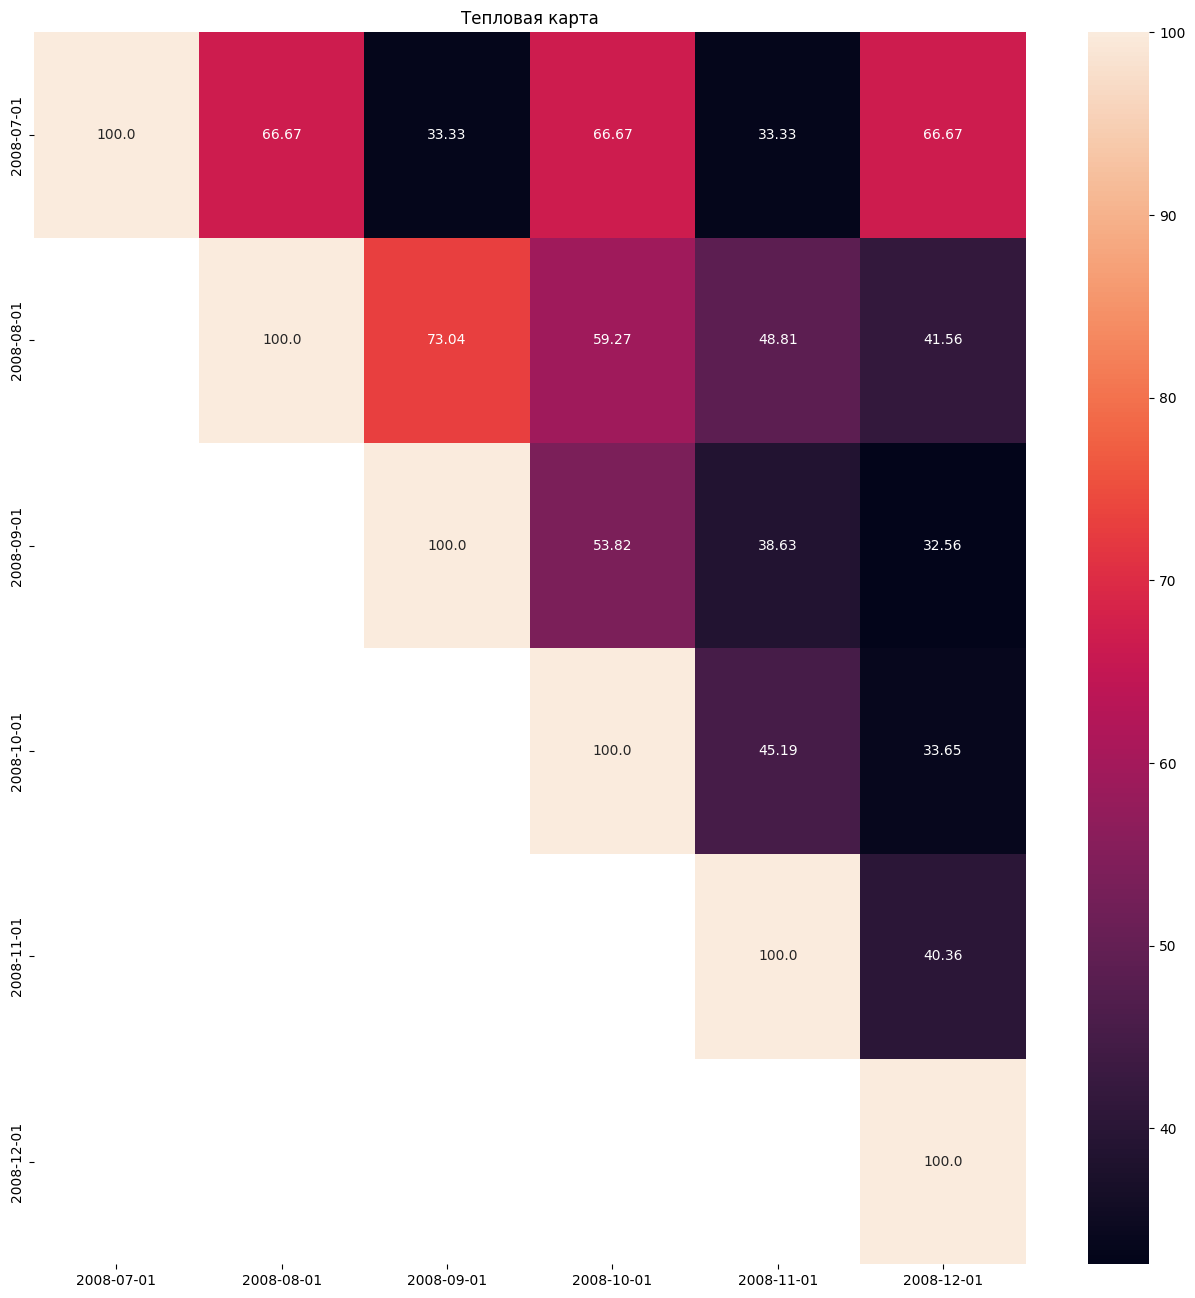

In [76]:
# создаём сводную таблицу с результатами
retention = sample_df_8.pivot(index='cohort_dt', columns='session_date', values='retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

Вывод: можно увидеть, что коэффицент удержания для всех когорт, за исключением той, что образовалась в июля, снижается к декабрю и показатели данного месяца являются минимлаьными для всех когорт за исключением июльской. Можно предположить, что данный факт связан с тем, что осенью люди больше заинтересованы в получение ответов на свои вопросы, так как учатся, а с наступлением декабря освоение нового материала прекращается из-за окончания календарного учебного года и каникул. Аномалией является когорта июля, так как коэффицент удержания пользователей данной когорты одинаков для августа, октября и декабря и составляет 66,67%, в то время как для сентября и ноября он составляет также одинаковые 33,33%. Данные цифры вызывают вопросы относительно корректности собранных данных. Возможно, стоит также проверить другие показатели именно июльской когорты, чтобы разобраться в аномалиях выявленных в коэффиценте удержания данной когорты по всем месяцам.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [77]:
# напишите запрос
query_9 = '''SELECT *, ROUND(((posts_count::numeric / LAG(posts_count) OVER (ORDER BY creation_month)) - 1) * 100,2) AS percentage
FROM (SELECT extract(month FROM creation_date::date) as creation_month, 
count(id) as posts_count
FROM stackoverflow.posts
WHERE creation_date BETWEEN '2008-09-01' AND '2008-12-31'
GROUP BY creation_month) as cnt
'''

# выполните запрос

In [78]:
sample_df_9 = pd.read_sql_query(query_9, con=engine)
sample_df_9

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


<details>

<summary>Подсказка</summary>
Эту задачу стоит декомпозировать. Сформируйте запрос, который отобразит номер месяца и количество постов. Затем можно использовать оконную функцию, которая вернёт значение за предыдущий месяц, и посчитать процент.
</details>

Постройте круговую диаграмму с количеством постов по месяцам.

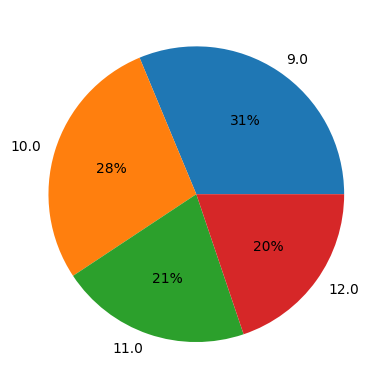

In [79]:
# постройте круговую диаграмму с количеством постов по месяцам
vals = sample_df_9['posts_count']
labels = sample_df_9['creation_month']

fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.00f%%')
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [80]:
# напишите запрос
query_10 = '''SELECT extract(week from creation_date) as week_creation, max(creation_date)
FROM stackoverflow.posts
WHERE date_trunc('month', creation_date) = '2008-10-01' AND
user_id = (SELECT user_id
FROM stackoverflow.posts
WHERE date_trunc('month', creation_date) = '2008-10-01'
GROUP BY user_id
ORDER BY count(id) DESC
limit 1)
GROUP BY week_creation
'''

# выполните запрос

In [81]:
sample_df_10 = pd.read_sql_query(query_10, con=engine)
sample_df_10

,week_creation,max
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01


<details>

<summary>Подсказка</summary>
Декомпозируйте задачу:
1) Найдите пользователя, который опубликовал больше всего постов. 2) Найдите дату и время создания каждого поста этого пользователя и номер недели. 
3) Отобразите данные только о последних постах пользователя. Для этого можно использовать оконную функцию.
</details>

# Задание 11

Найдите количество вопросов, которые набрали больше 300 очков или как минимум 100 раз были добавлены в «Закладки».

In [82]:
# напишите запрос
query_11 = '''SELECT count(id)
FROM stackoverflow.posts
WHERE favorites_count >=100 OR score >=300
'''

# выполните запрос

In [83]:
sample_df_11 = pd.read_sql_query(query_11, con=engine)
sample_df_11

,count
0,2573


<details>

<summary>Подсказка</summary>
Чтобы отфильтровать данные, используйте логические операторы AND и OR. Обратите внимание на приоритет выполнения этих операторов.
</details>

# Задание 12

Сколько в среднем в день задавали вопросов с 1 по 18 ноября 2008 включительно? Результат округлите до целого числа.

In [84]:
# напишите запрос
query_12 = '''SELECT round(avg(count))
FROM (SELECT date_trunc('day', creation_date) as dt, count(date_trunc('day', creation_date))
FROM stackoverflow.posts
WHERE creation_date >='2008-11-01' AND creation_date <= '2008-11-18'
GROUP BY dt) day_post
'''

# выполните запрос

In [85]:
sample_df_12 = pd.read_sql_query(query_12, con=engine)
sample_df_12

,round
0,1588.0


<details>

<summary>Подсказка</summary>
Делая срез, обратите внимание на тип данных поля c датой поста. Сгруппируйте записи по дням и найдите количество вопросов в день, а после посчитайте среднее.
</details>

# Задание 13

Сколько пользователей получили значки сразу в день регистрации? Выведите количество уникальных пользователей.

In [86]:
# напишите запрос
query_13 = '''SELECT count(u.id)
FROM stackoverflow.badges as b
JOIN stackoverflow.users as u ON b.user_id = u.id
WHERE date_trunc('day', b.creation_date) = date_trunc('day', u.creation_date)
'''

# выполните запрос

In [87]:
sample_df_13 = pd.read_sql_query(query_13, con=engine)
sample_df_13

,count
0,13041


<details>

<summary>Подсказка</summary>
Данные о пользователях хранит таблица users, а данные о значках — таблица badges. Соедините их.
</details>

# Задание 14

Сколько уникальных постов пользователя с именем Joel Coehoorn получили хотя бы один голос?

In [88]:
# напишите запрос
query_14 = '''SELECT DISTINCT count(p.id)
FROM stackoverflow.users as u
JOIN stackoverflow.posts as p ON p.user_id = u.id
WHERE u.display_name = 'Joel Coehoorn' AND p.score > 1
'''

# выполните запрос

In [89]:
sample_df_14 = pd.read_sql_query(query_14, con=engine)
sample_df_14

,count
0,478


<details>

<summary>Подсказка</summary>
Присоедините несколько таблиц, чтобы собрать все нужные данные.
</details>

# Задание 15

Выгрузите все поля таблицы vote_types. Добавьте к таблице поле rank, в которое войдут номера записей в обратном порядке. Таблица должна быть отсортирована по полю id.

In [90]:
# напишите запрос
query_15 = '''SELECT *, RANK() OVER(ORDER BY id DESC)
FROM stackoverflow.vote_types
ORDER BY id
'''

# выполните запрос

In [91]:
sample_df_15 = pd.read_sql_query(query_15, con=engine)
sample_df_15

,id,name,rank
0,1,AcceptedByOriginator,15
1,2,UpMod,14
2,3,DownMod,13
3,4,Offensive,12
4,5,Favorite,11
5,6,Close,10
6,7,Reopen,9
7,8,BountyStart,8
8,9,BountyClose,7
9,10,Deletion,6


<details>

<summary>Подсказка</summary>
Чтобы пронумеровать записи в обратном порядке, используйте оконную функцию.
</details>

# Задание 16

Отберите 10 пользователей, которые поставили больше всего голосов типа Close. Отобразите таблицу из двух полей: идентификатором пользователя и количеством голосов. Отсортируйте данные сначала по убыванию количества голосов, потом по убыванию значения идентификатора пользователя.

In [92]:
# напишите запрос
query_16 = '''SELECT DISTINCT p.user_id, count(vt.name)
FROM stackoverflow.posts as p
JOIN stackoverflow.votes as v ON v.post_id = p.id
JOIN stackoverflow.vote_types as vt ON vt.id = v.vote_type_id
WHERE vt.name = 'Close'
GROUP BY p.user_id
ORDER BY count DESC
LIMIT 10
'''

# выполните запрос

In [93]:
sample_df_16 = pd.read_sql_query(query_16, con=engine)
sample_df_16

,user_id,count
0,31505,66
1,303,46
2,4230,46
3,91,37
4,15985,32
5,383,29
6,1,24
7,2443,24
8,6461,24
9,2915,22


<details>

<summary>Подсказка</summary>
Таблицы vote_types и users не связаны напрямую, поэтому вам понадобится присоединить несколько таблиц. Не забудьте добавить условие.
</details>

# Задание 17


Отберите 10 пользователей по количеству значков, полученных в период с 15 ноября по 15 декабря 2008 года включительно.  
Отобразите несколько полей:
* идентификатор пользователя;
* число значков;
* место в рейтинге — чем больше значков, тем выше рейтинг.  

Пользователям, которые набрали одинаковое количество значков, присвойте одно и то же место в рейтинге.
Отсортируйте записи по количеству значков по убыванию, а затем по возрастанию значения идентификатора пользователя.

In [94]:
# напишите запрос
query_17 = '''SELECT *, DENSE_RANK() OVER(ORDER BY count DESC)
FROM
(SELECT user_id, count(user_id)
FROM stackoverflow.badges
WHERE creation_date >= '2008-11-15' AND
creation_date <='2008-12-15'
GROUP BY user_id
ORDER BY count DESC) as cnt
LIMIT 10
'''

# выполните запрос

In [95]:
sample_df_17 = pd.read_sql_query(query_17, con=engine)
sample_df_17

,user_id,count,dense_rank
0,22656,137,1
1,34509,44,2
2,1288,39,3
3,5190,31,4
4,13913,29,5
5,10661,28,6
6,893,26,7
7,33213,25,8
8,12950,22,9
9,33987,18,10


<details>

<summary>Подсказка</summary>
Чтобы назначить места в рейтинге, воспользуйтесь оконной функцией ранжирования.
</details>

# Задание 18

Сколько в среднем очков получает пост каждого пользователя?
Сформируйте таблицу из следующих полей:  
* заголовок поста;
* идентификатор пользователя;
* число очков поста;
* среднее число очков пользователя за пост, округлённое до целого числа.
  
Не учитывайте посты без заголовка, а также те, что набрали ноль очков.

In [96]:
# напишите запрос
query_18 = '''SELECT title, user_id, score, round(avg(score) OVER(ORDER BY user_id))
FROM stackoverflow.posts
WHERE title != '' and score > 0
'''

# выполните запрос

In [97]:
sample_df_18 = pd.read_sql_query(query_18, con=engine)
sample_df_18

,title,user_id,score,round
0,How do I calculate someone's age in C#?,1,1743,573.0
1,Why doesn't IE7 copy <pre><code> blocks to the...,1,37,573.0
2,Practical non-image based CAPTCHA approaches?,1,318,573.0
3,Diagnosing Deadlocks in SQL Server 2005,1,82,573.0
4,Wrapping StopWatch timing with a delegate or l...,1,92,573.0
...,...,...,...,...
47024,Multi-lingual projects in Visual Studio,3742716,1,37.0
47025,Change datatype when importing Excel file into...,3930756,5,37.0
47026,How to host a Silverlight app in a Sharepoint ...,4020932,8,37.0
47027,Getting counts for a paged SQL search stored p...,5696608,2,37.0


<details>

<summary>Подсказка</summary>
Используйте оконную функцию и укажите поле, по которому сформировать окна.
</details>

# Задание 19

Отобразите заголовки постов, которые были написаны пользователями, получившими более 1000 значков. Посты без заголовков не должны попасть в список.

In [98]:
# напишите запрос
query_19 = '''SELECT title
FROM (SELECT DISTINCT p.title, count(b.user_id) OVER(PARTITION BY b.user_id) as count
FROM stackoverflow.posts as p
JOIN stackoverflow.users as u ON u.id = p.user_id
JOIN stackoverflow.badges as b ON b.user_id = u.id) as ttl
WHERE count >= 1000 AND title != ''
'''

# выполните запрос

In [99]:
sample_df_19 = pd.read_sql_query(query_19, con=engine)
sample_df_19

,title
0,How do you structure your URL routes?
1,How do I recover from an unchecked exception?
2,Excel: list ranges targeted by INDIRECT formulas
3,How is data compression more effective than in...
4,Automating VMWare or VirtualPC
...,...
21452,Buildfarms : Options
21453,Generating a Reporting Services 2005 PDF repor...
21454,Is there any good replacement for SharePoint D...
21455,How do I determine what target is calling my c...


<details>

<summary>Подсказка</summary>
Это задание лучше выполнить по частям. Сформируйте список пользователей, которые заработали больше 1000 значков. С помощью этого списка можно отфильтровать записи в основном запросе.
</details>

# Задание 20

Напишите запрос, который выгрузит данные о пользователях из США (англ. United States). Разделите пользователей на три группы в зависимости от количества просмотров их профилей:  
* пользователям с числом просмотров больше либо равным 350 присвойте группу 1;
* пользователям с числом просмотров меньше 350, но больше либо равно 100 — группу 2;
* пользователям с числом просмотров меньше 100 — группу 3.  

Отобразите в итоговой таблице идентификатор пользователя, количество просмотров профиля и группу. Пользователи с нулевым количеством постов не должны войти в итоговую таблицу.

In [100]:
# напишите запрос
query_20 = '''SELECT id, views, 
CASE 
    WHEN views >= 350 THEN '1'
    WHEN views >=100 THEN '2'
    ELSE  '3'
END as group_n
FROM stackoverflow.users
WHERE location = 'United States' AND id in (SELECT user_id FROM stackoverflow.posts)
'''

# выполните запрос

In [101]:
sample_df_20 = pd.read_sql_query(query_20, con=engine)
sample_df_20

,id,views,group_n
0,4321,1049,1
1,32144,32,3
2,1595,348,2
3,23468,118,2
4,31761,8,3
...,...,...,...
1432,26259,165,2
1433,41703,20,3
1434,35696,780,1
1435,1613178,87,3


# Задание 21

Дополните предыдущий запрос. Отобразите лидеров каждой группы — пользователей, которые набрали максимальное число просмотров в своей группе. Выведите поля с идентификатором пользователя, группой и количеством просмотров. Отсортируйте таблицу по убыванию просмотров, а затем по возрастанию значения идентификатора.

In [102]:
# напишите запрос
query_21 = '''SELECT id, views, 
CASE 
    WHEN views >= 350 THEN '1'
    WHEN views >=100 THEN '2'
    ELSE  '3'
END as group_n
FROM stackoverflow.users 
WHERE location = 'United States' AND id in (SELECT user_id FROM stackoverflow.posts)
ORDER BY views DESC
'''

# выполните запрос

In [103]:
sample_df_21 = pd.read_sql_query(query_21, con=engine)
sample_df_21

,id,views,group_n
0,1228,58635,1
1,36305,43436,1
2,13531,30601,1
3,6380,22473,1
4,9530,18685,1
...,...,...,...
1432,47299,8,3
1433,9100,8,3
1434,18010,7,3
1435,2571124,7,3


<details>

<summary>Подсказка</summary>
Дополните предыдущий запрос. Отобразите лидеров каждой группы — пользователей, которые набрали максимальное число просмотров в своей группе. Выведите поля с идентификатором пользователя, группой и количеством просмотров. Отсортируйте таблицу по убыванию просмотров, а затем по возрастанию значения идентификатора.
</details>

# Задание 22

Посчитайте ежедневный прирост новых пользователей в ноябре 2008 года. Сформируйте таблицу с полями:
* номер дня;
* число пользователей, зарегистрированных в этот день;
* сумму пользователей с накоплением.

In [104]:
# напишите запрос
query_22 = '''SELECT *, sum(count) OVER(ORDER BY date_part)
FROM (SELECT DISTINCT extract(day from creation_date) as date_part, 
count(id) over(PARTITION BY extract(day from creation_date))
FROM stackoverflow.users
WHERE date_trunc('month', creation_date) = '2008-11-01') as cnt
'''

# выполните запрос

In [105]:
sample_df_22 = pd.read_sql_query(query_22, con=engine)
sample_df_22

,date_part,count,sum
0,1.0,34,34.0
1,2.0,48,82.0
2,3.0,75,157.0
3,4.0,192,349.0
4,5.0,122,471.0
5,6.0,132,603.0
6,7.0,104,707.0
7,8.0,42,749.0
8,9.0,45,794.0
9,10.0,93,887.0


<details>

<summary>Подсказка</summary>
Для подсчёта суммы с накоплением вам понадобится оконная функция. Не забудьте отфильтровать таблицу по месяцу и году.
</details>

# Задание 23

Для каждого пользователя, который написал хотя бы один пост, найдите интервал между регистрацией и временем создания первого поста. Отобразите:
* идентификатор пользователя;
* разницу во времени между регистрацией и первым постом.

In [106]:
# напишите запрос
query_23 = '''SELECT p.user_id, min(p.creation_date - u.creation_date)
FROM stackoverflow.posts as p
JOIN stackoverflow.users as u ON p.user_id = u.id
GROUP BY user_id
'''

# выполните запрос

In [107]:
sample_df_23 = pd.read_sql_query(query_23, con=engine)
sample_df_23 

,user_id,min
0,30052,0 days 03:04:47
1,24416,0 days 00:21:57
2,4790,0 days 00:17:15
3,47051,2 days 03:02:01
4,37083,4 days 14:33:15
...,...,...
18844,49794,0 days 00:00:00
18845,34957,0 days 00:17:18
18846,4035,2 days 03:31:44
18847,4827,3 days 20:54:03


<details>

<summary>Подсказка</summary>
Для каждого пользователя найдите время создания первого поста с помощью оконной функции ранжирования. Если от этого времени отнять дату регистрации пользователя, получится нужный интервал. Не меняйте тип данных поля creation_date.
</details>